# Reapply existing signatures

Simple example of fitting the provided example data to the 5 ES model

In [1]:
from cvanmf import models
import numpy as np

# The example data is quite large, so we'll take a subset of samples
result = models.five_es().reapply(
    y=models.example_abundance().iloc[:, :30]
)

result.model_fit.describe()

count    30.000000
mean      0.797996
std       0.185145
min       0.203682
25%       0.763434
50%       0.862407
75%       0.930804
max       0.974751
Name: model_fit, dtype: float64

<Figure size 100x100 with 0 Axes>

The results object is a Decomposition class object. The Enterosignature weights for each sample are in the H matrix of the results object.

In [2]:
result.h.head().iloc[:, :5]

,W2.35.ST,W1.41.ST,W2.42.ST,W1.39.ST,M1.61.ST
ES_Bact,1.088325e-03,0.000057,5.533855e-06,2.797162e-15,5.123730e-07
ES_Bifi,2.782562e-08,0.000582,2.067819e-03,6.447965e-03,9.524048e-05
ES_Esch,7.382243e-04,0.000032,1.588800e-02,1.233557e-03,4.232990e-03
ES_Prev,1.778084e-02,0.037536,3.071650e-02,2.887819e-02,3.282901e-02
ES_Firm,1.282287e-02,0.004567,2.772057e-15,5.027370e-03,4.772470e-03


We can get a scaled version of the H matrix (so each sample sums to 1), and visualise this using a mix of the inbuilt methods.

In [3]:
assert np.allclose(result.scaled('h').sum(), 1.0)
result.scaled('h').iloc[:, :5]

,W2.35.ST,W1.41.ST,W2.42.ST,W1.39.ST,M1.61.ST
ES_Bact,3.355890e-02,0.001341,1.136832e-04,6.726035e-14,0.000012
ES_Bifi,8.580131e-07,0.013607,4.247966e-02,1.550473e-01,0.002271
ES_Esch,2.276342e-02,0.000748,3.263907e-01,2.966203e-02,0.100953
ES_Prev,5.482788e-01,0.877526,6.310159e-01,6.944029e-01,0.782944
ES_Firm,3.953980e-01,0.106778,5.694698e-14,1.208878e-01,0.113819


The relative weights can be plotted as a stacked bar, using the `plot_relative_weight` method. By default, the top part of this plot shows the model fit of each sample (the cosine angle between the sample and X and in WH), with 1 being good and 0 bad. A default line of 0.4 for "poor model fit" is given, based on the Enterosignatures paper. Below this is a stacked bar plot, showing the relative abundance of each signature in each sample.

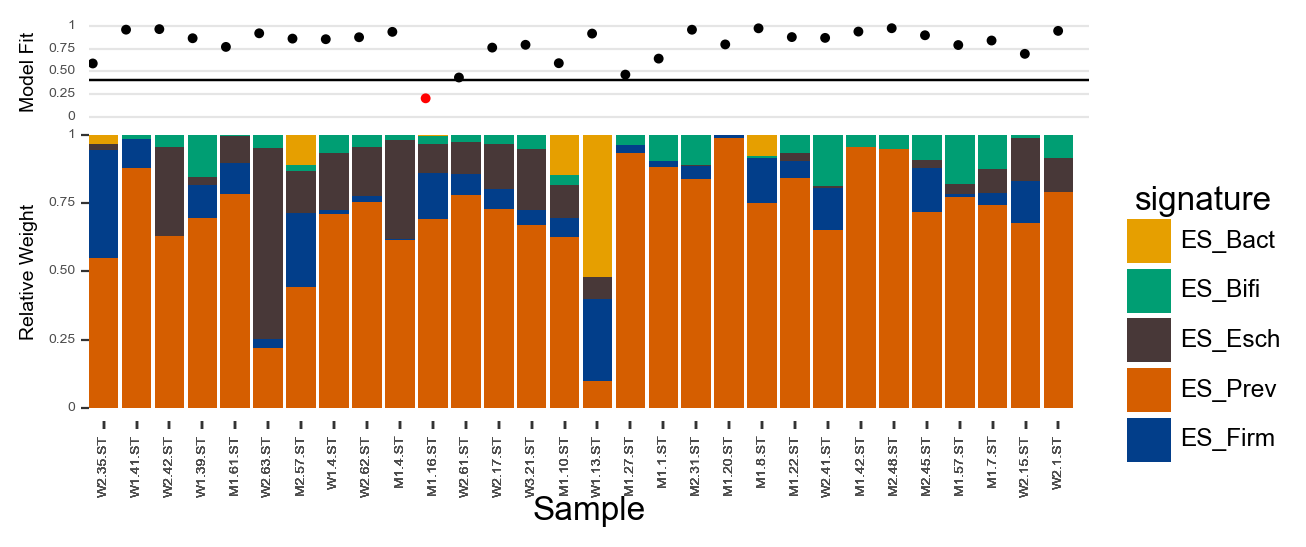

In [4]:
# The heights parameter controls the height in inches of each bit
result.plot_relative_weight(heights=[0.5, 1.5], width=5)

# De-novo signatures

We can attempt to discover signatures from new data. For these examples we will use a simple synthetic dataset with 4 signatures which slightly overlap.

In [5]:
import seaborn as sns
import pathlib
from cvanmf.denovo import rank_selection, plot_rank_selection, decompositions, Decomposition

<Axes: >

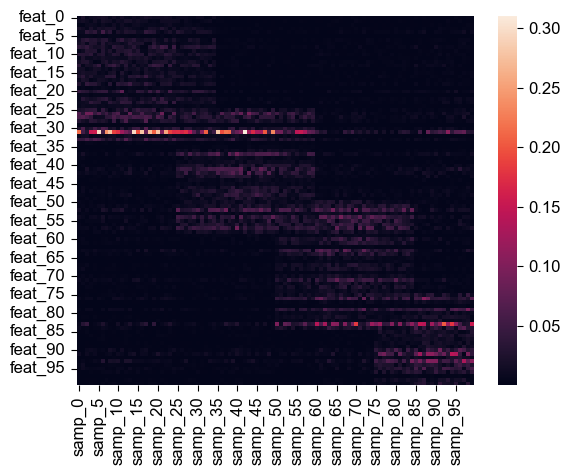

In [6]:
x = models.synthetic_data(
    overlap=0.4, 
    k=4, 
    scale_lognormal_params=dict(sigma=0.75)
)
# Each feature is assigned a weight drawn from a lognormal distribution, to roughly simulate some features (such a taxon) 
# generally taking higher values in input data.
sns.heatmap(x)

## Rank selection
The number of ranks $k$ is unknown, however we can attempt to estimate it using bi-crossvalidation. This tries learning a held out part of the data using the other parts for a range of ranks a large number of times, and we look at measures of how well the held out part was estimated to identify a suitable rank. These are run from largest rank to smallest, so the estimate of time tends to start of conservative.

In [12]:
rank_sel_res = rank_selection(x=x, ranks=range(2, 7), shuffles=20, seed=4298, progress_bar=False)
# shuffles sets the number iterations of bi-crossvalidation which are run. 
# The default is 100, it has been set lower here to make the documentation easier to compile, but 100 is a more 
# sensible value for real data

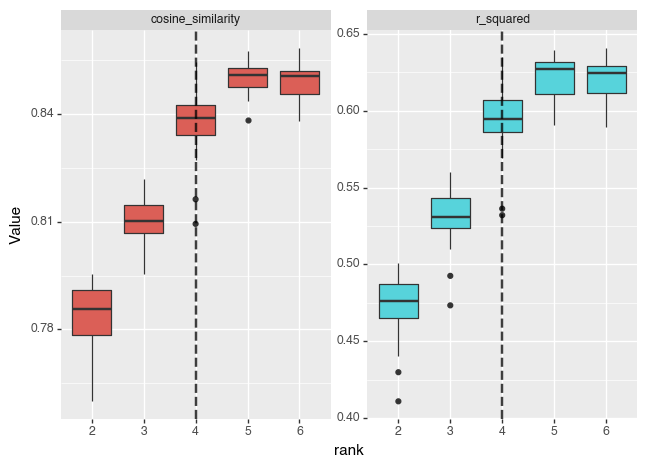

<Figure Size: (640 x 480)>

In [11]:
plot_rank_selection(rank_sel_res, jitter=False, n_col=3)

In these plots you are typically looking for elbow points; ranks after which the quality of the decomposition does not improve as rapidly, suggesting that adding more signatures is no longer contributing much explanatory power.

In our example, cosine similarity increases rapidly until $k=4$ where the rate of increase slows, indicating this is a suitable rank. Real world examples will rarely be so clear, and often several ranks will appear suitable.

The different measures here are:
* *Cosine Similarity*: Higher is better. The angle between the true data and estimated data, considering each as a flattened 1d vector
* *L2 Norm*: Euclidean distance between true and estimated data. Lower is better.
* *R-squared*: Coefficient of determination between true and estimated data. Higher is better.
* *Reconstruction Error*: Measure of the error in the estimated data compared to true. Lower is better.
* *Residual Sum of Sqaures*: Lower is better
* *Sparsity H*: Sparsity of the H matrix
* *Sparsity W*: Sparsity of the W matrix

When there are several candidate ranks, it is useful to generate decompositions for each and manually inspect them. This is usually the case, and some researcher judgement is required in eventually selecting which rank decomposition to use.

## Regularisation selection

#### Background
$L1$ regularisation can be applied to encourage sparsity in the decomposition (fewer entries in $W$ and $H$ with high values).
A sparse solution can have benefits for intuitive understanding, for instance if we are decomposing a table of genes, a signature with high weights for a few genes, rather than lower weights for many genes, can be easier to interpret biologically. 

$L2$ regularisation instead encourages a more even distribution of weights across in both $W$ and $H$, leading to more evenly distributed weights and lower sparsity.

The degree of regularisation is controlled by two parameters, $l1\_ratio$ and $alpha$ from the underlying NMF implementation we use from `scikit-learn`. Currently regularisation is applied to both the $H$ and $W$ matrices, though `sklearn` supports only applying to one.

* $l1\_ratio$ - Between 0 and 1, with 1 applying only $L1$ regularisation, and 0 applying only $L2$ regularisation, and any value between being a mix.
* $alpha$ - Regularisation coefficient. A value of 0 means applying no regularisation. By default when selecting an $alpha$ parameter, `cvanmf` will try values $2^i$ for $i \in \{-5, -4, \dots, 2\}$

### Application
We give an example here of $L1$ regularisation to encourage sparsity. `cvanmf` provides the function `regu_selection` to test values of $alpha$ for a given $l1\_ratio$. As we want a sparse solution, we will use $l1\_ratio = 1$. The function only accepts one rank, we have to have already selected the rank of decomposition we want.

In [13]:
from cvanmf.denovo import regu_selection, plot_regu_selection

In [14]:
best_alpha, regu_sel_res = regu_selection(x=x, rank=4, shuffles=20, seed=4298, l1_ratio=1.0, progress_bar=False)
# shuffles sets the number iterations of bi-crossvalidation which are run. 
# The default is 100, it has been set lower here to make the documentation easier to compile, but 100 is a more 
# sensible value for real data

In [15]:
best_alpha

0.0003125

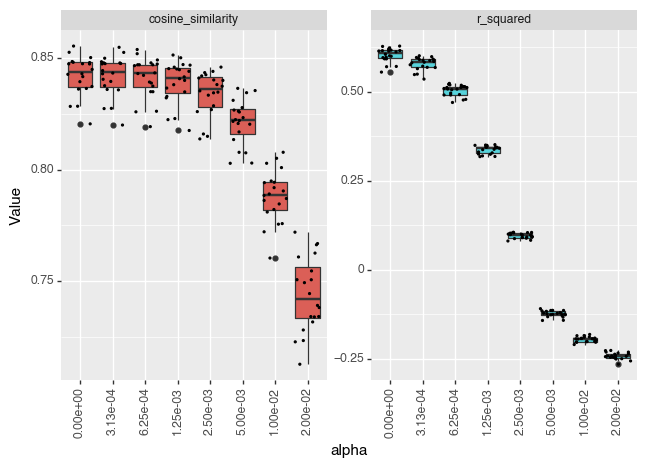

<Figure Size: (640 x 480)>

In [16]:
plot_regu_selection(regu_sel_res)

A higher value of alpha leads to greater sparsity, although in this case not by much until high values of $alpha$. However, the measure of how well the decomposition reconstructs the input data also monotonically decrease as $alpha$ increases. `cvanmf` by default identifies the tested value of $alpha$ for which the $R^2$ is not significantly worse than $alpha=0$, which is returned as the first element of the results.

In [17]:
best_alpha

0.0003125

## Generating decompositions
For the ranks of interest, we can generate several decompositions to investigate. NMF solutions are non-unique and depend on the initialisation of the $H$ and $W$ matrices; some initialisations may give a better solution than others. One approach is to make many decompositions, and select those which optimise some criteria, such as reconstruction error.

Here we make 100 decompositions for each of ranks 3, 4, and 5, and keep only the top 5 for each rank. The result is a dictionary, with the key being the rank, and the value a list of Decompositions with the first being the best (lowest reconstruction error).

In [18]:
decomps = decompositions(x, ranks=[3, 4, 5], top_n=5, random_starts=5, seed=4928, progress_bar=False)
# or to use regularisation
# decomps = decompositions(x, ranks=[3, 4, 5], top_n=5, random_starts=5, seed=4928, l1_ratio=1.0, alpha=best_alpha)
decomps

{3: [Decomposition[rank=3, beta_divergence=22.5],
  Decomposition[rank=3, beta_divergence=22.5],
  Decomposition[rank=3, beta_divergence=22.5],
  Decomposition[rank=3, beta_divergence=22.5],
  Decomposition[rank=3, beta_divergence=22.6]],
 4: [Decomposition[rank=4, beta_divergence=16.5],
  Decomposition[rank=4, beta_divergence=16.5],
  Decomposition[rank=4, beta_divergence=16.5],
  Decomposition[rank=4, beta_divergence=16.5],
  Decomposition[rank=4, beta_divergence=16.5]],
 5: [Decomposition[rank=5, beta_divergence=14.9],
  Decomposition[rank=5, beta_divergence=14.9],
  Decomposition[rank=5, beta_divergence=14.9],
  Decomposition[rank=5, beta_divergence=14.9],
  Decomposition[rank=5, beta_divergence=15.7]]}

You can use regularisation parameters here, but be aware the than same $alpha$ is applied to all ranks, which may not be suitable as $alpha$ is selected for a decomposition of specific rank.

We can inspect the decompositions using some inbuilt plotting functions

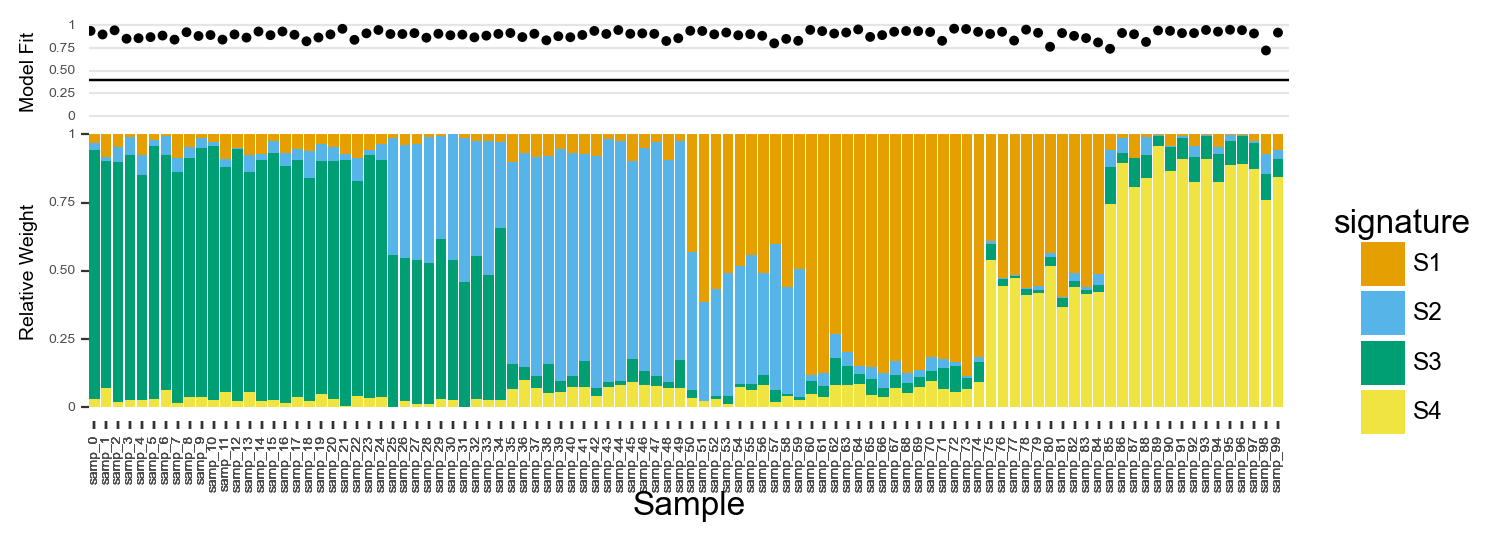

In [16]:
decomps[4][0].plot_relative_weight(heights=[0.5, 1.5])

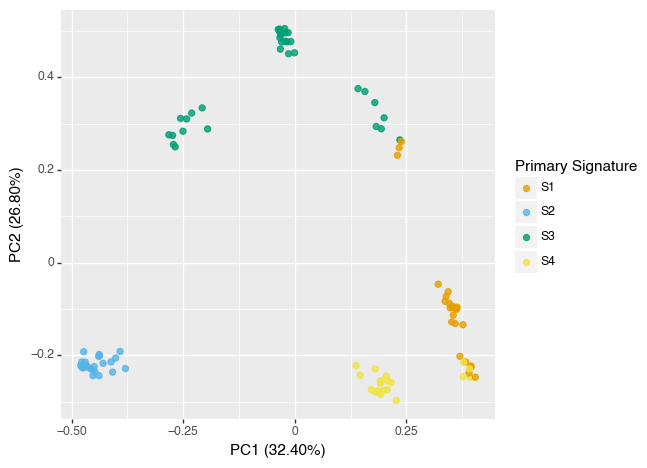

<Figure Size: (640 x 480)>

In [19]:
decomps[4][0].plot_pcoa()

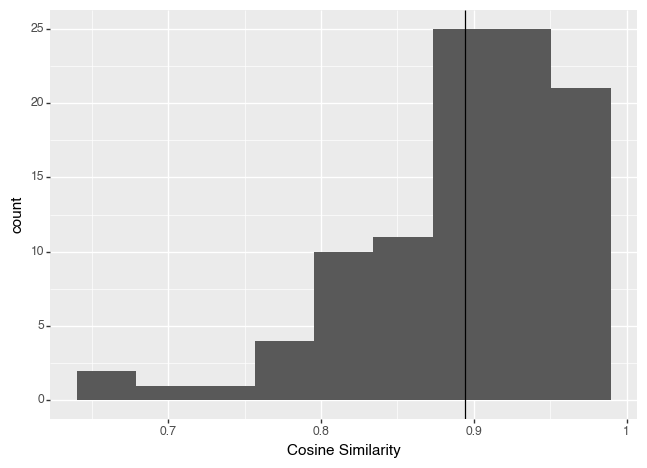

<Figure Size: (640 x 480)>

In [20]:
decomps[4][0].plot_modelfit()

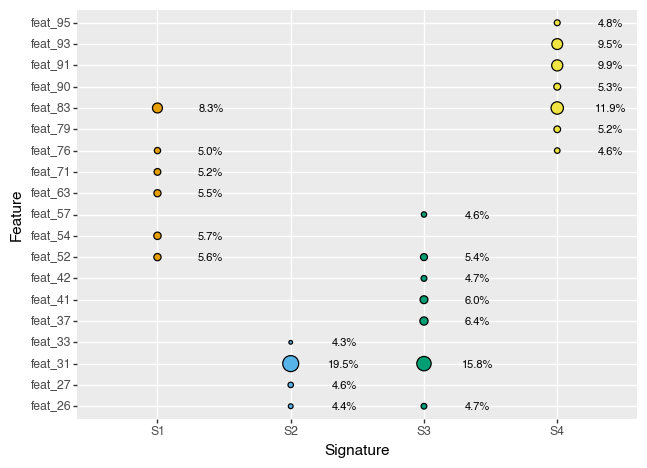

<Figure Size: (640 x 480)>

In [21]:
decomps[4][0].plot_feature_weight()

### Reapplying this model

Now that we have generated a model, we can reapply it to new data. We'll make two datasets:
* y_similar: Has exactly the same properties as our original X. The model should describe this well.
* y_different: Has fewer features, and different number of blocks, so should handle this poorly.

<Axes: >

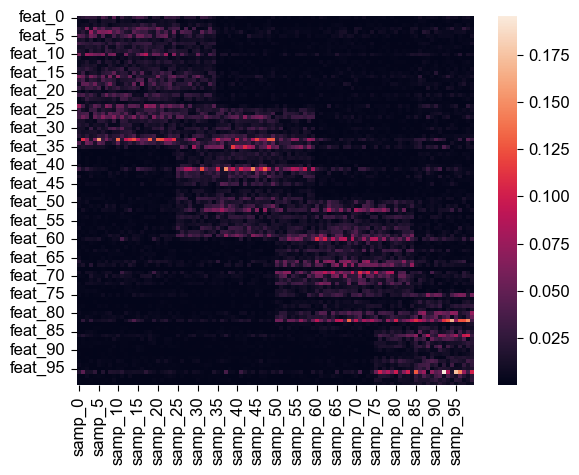

In [22]:
y_similar = models.synthetic_data(
    overlap=0.4, 
    k=4, 
    scale_lognormal_params=dict(sigma=0.75)
)
sns.heatmap(y_similar)

<Axes: >

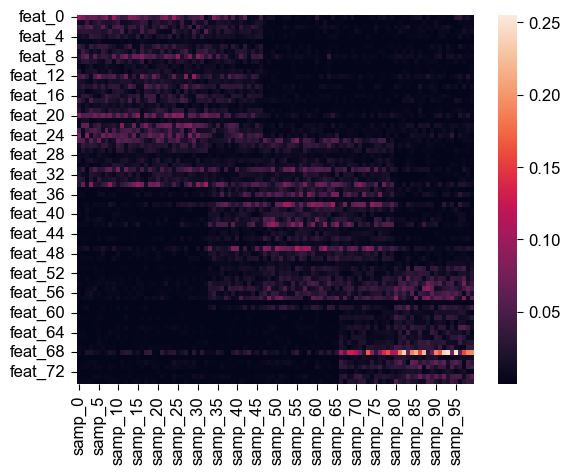

In [23]:
y_different = models.synthetic_data(
    m=75,
    overlap=0.4, 
    k=3, 
    scale_lognormal_params=dict(sigma=0.75)
)
sns.heatmap(y_different)

Applying our existing model to the data is simple...

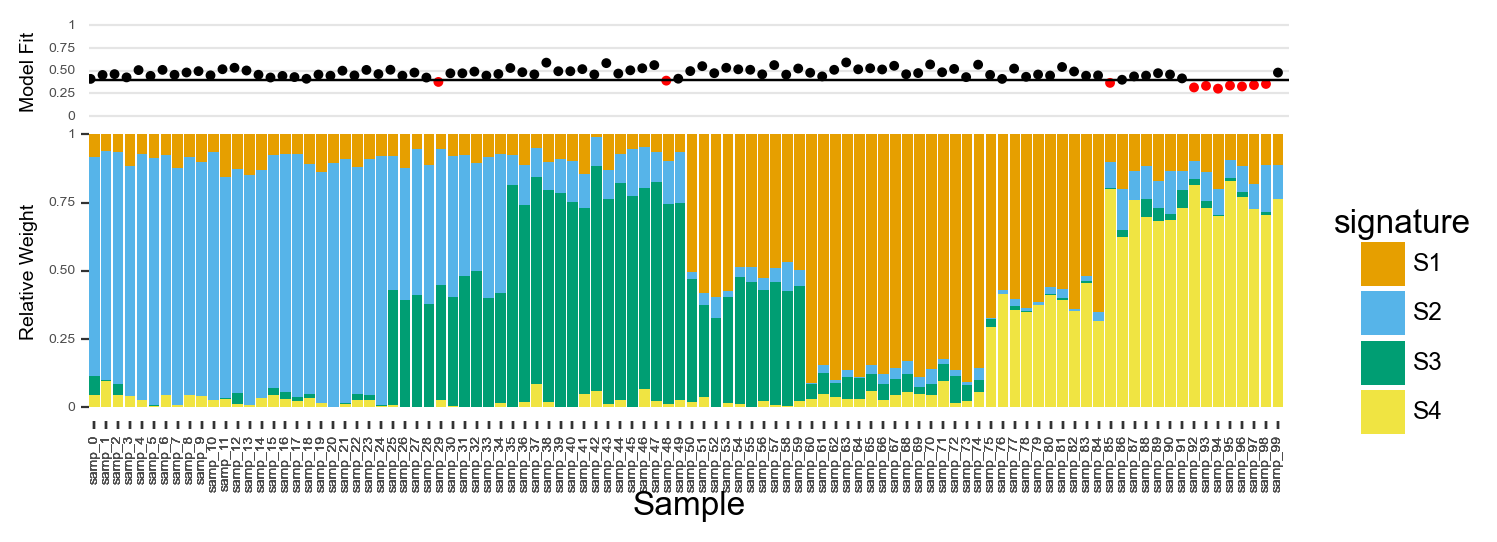

In [24]:
d_similar = decomps[4][0].reapply(
    y=y_similar
)
d_similar.plot_relative_weight(heights=[0.5, 1.5])

For the similar data, the model looks to have described the data reasonably well, with overlapping blocks of signatures.

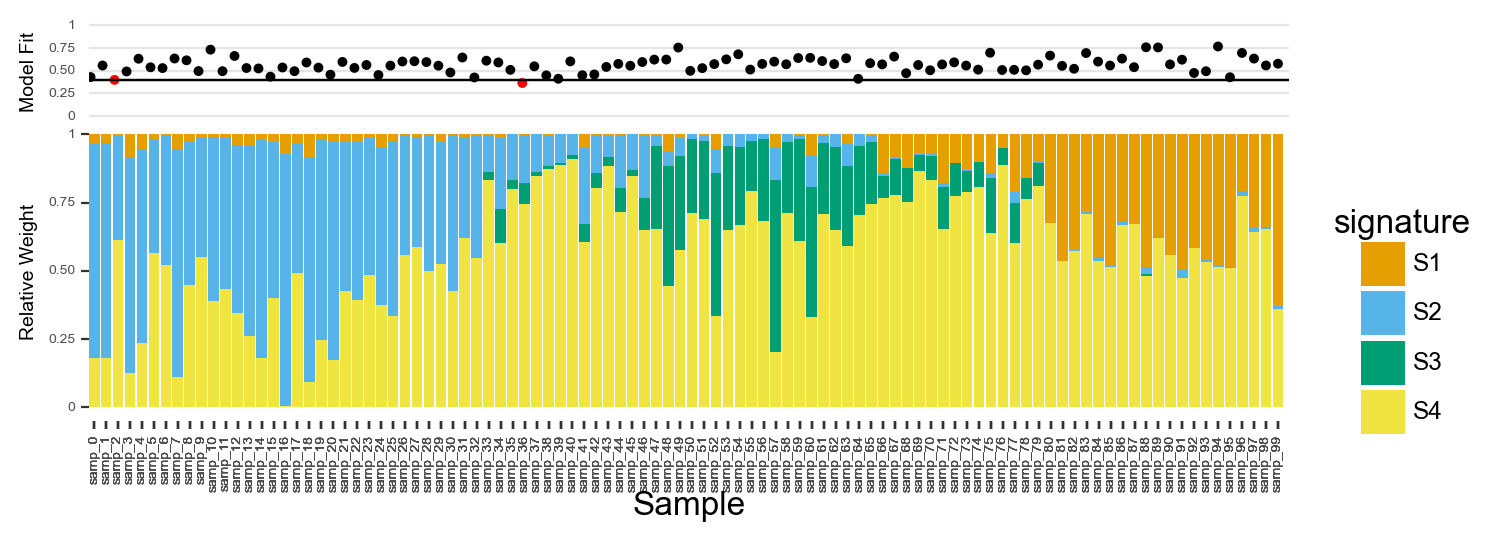

In [25]:
d_different = decomps[4][0].reapply(
    y=y_different
)
d_different.plot_relative_weight(heights=[0.5, 1.5])

For dissimilar data is has still performed okay. If we look at the decomposition, we can see that to align the data `cvanmf` has removed from the signature weight matrix and features which are not in the new data (y_different), so only 75 features are used here.

In [28]:
decomps[4][0].w.loc[d_different.w.index] == d_different.w

,S1,S2,S3,S4
feat_0,True,True,True,True
feat_1,True,True,True,True
feat_2,True,True,True,True
feat_3,True,True,True,True
feat_4,True,True,True,True
...,...,...,...,...
feat_70,True,True,True,True
feat_71,True,True,True,True
feat_72,True,True,True,True
feat_73,True,True,True,True


## Slicing decompositions

We might be interested in visualising or analysis only a subset of a decomposition; perhaps we only want to look at one cohort of samples in a model, or only at some of the signatures. Decomposition objects can be indexed by sample, feature, and signature in that order. Normal slice syntax (1:5), lists of index names, or lists of index positions are supported. You can supply a mix of these.

This can also be used for abitrary reordering of samples and features for visualisations.

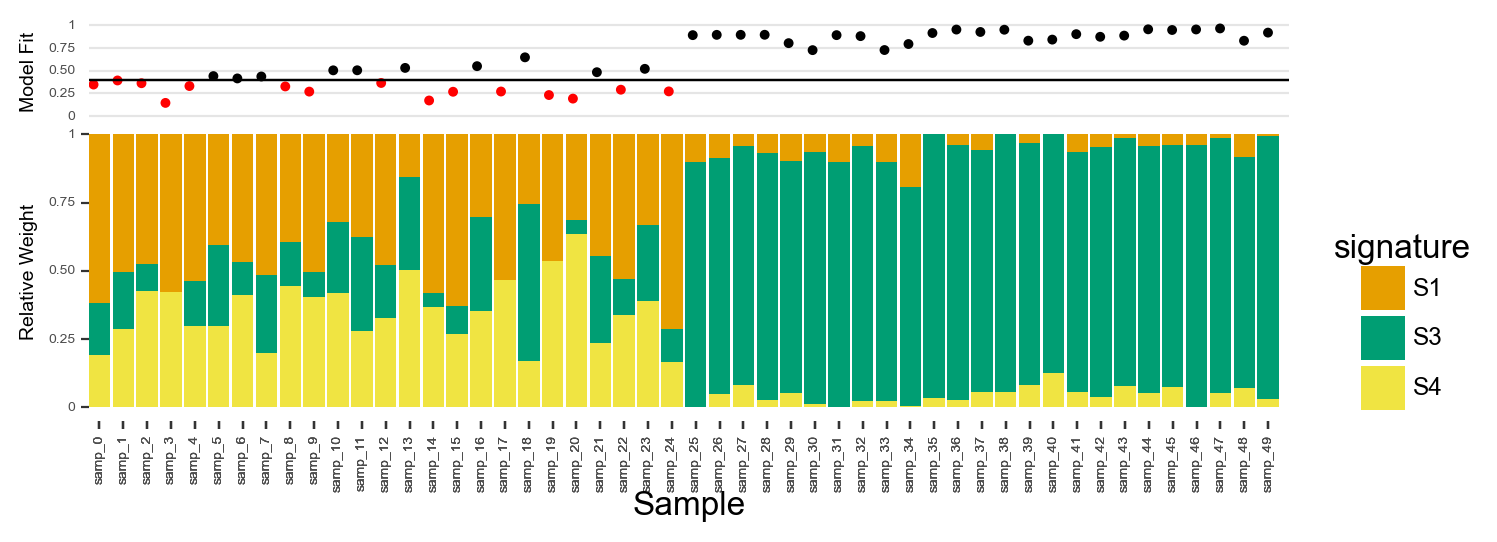

In [29]:
decomp_slcd = decomps[4][0][:50, :, ["S1", "S3", "S4"]]
decomp_slcd.plot_relative_weight(heights=[0.5, 1.5])

Here we have restricted to just the first 50 samples, and only signatures S1, S3 and S4. In the full decomposition, S2is important to described many samples from samp_35 to samp_49, so the model fit for these is much poorer in this reduced model.

Another potential use for the slicing syntax is to reorder samples based on some metadata condition. The method is illustrated below with a random reordering.

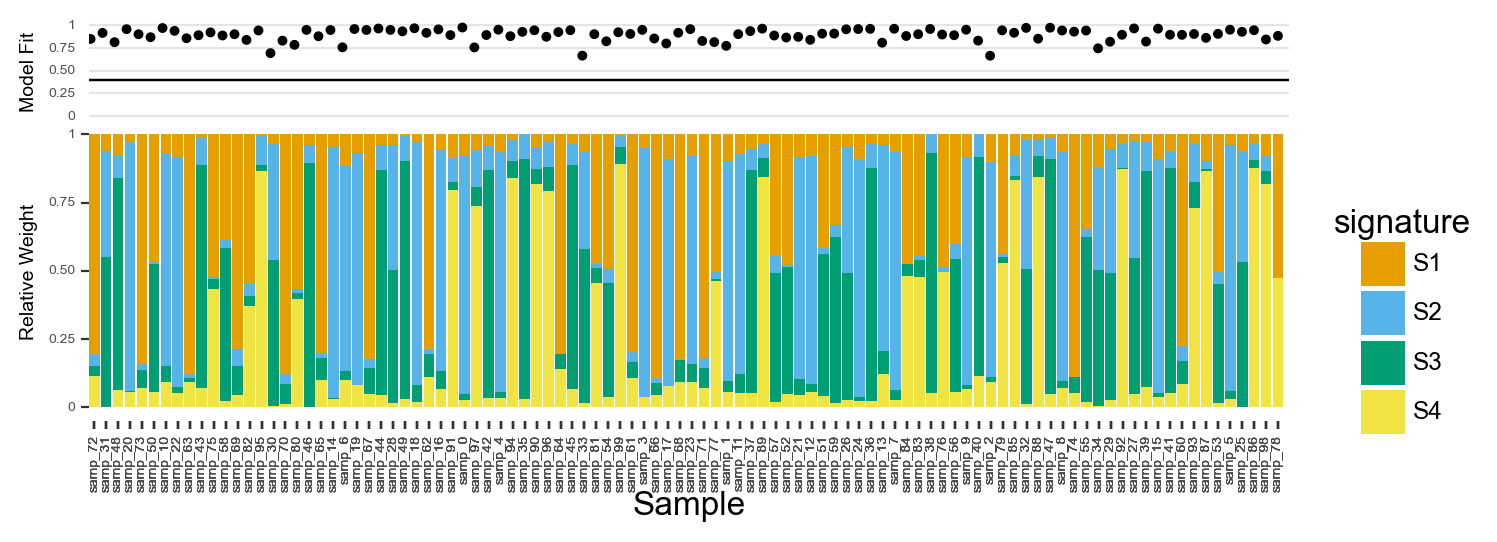

In [30]:
# Reorder samples - here we're just generating a random order
import random
new_order = list(range(decomps[4][0].h.shape[1]))
random.shuffle(new_order)

# Reorder the decomposition
decomps[4][0][new_order].plot_relative_weight(heights=[0.5, 1.5])

## Saving and loading
Decompositions can be saved to disk for analysis in other environments, or saved and reloaded later.

In [31]:
Decomposition.save_decompositions(decomps, output_dir=pathlib.Path("test_save"), symlink=False, plots=False)
# We're not writing any plots here (as they take some time), but you can set this to
# - True: make all plots
# - List of plots names: make all the listed plots
# - None: Make all plots, unless there are many samples (>250), in which case omit any plots which have an element for each sample

In [32]:
! ls test_save/**/**

test_save/3/0:
h.tsv                         properties.yaml
h_scaled.tsv                  quality_series.tsv
model_fit.tsv                 representative_signatures.tsv
monodominant_samples.tsv      w.tsv
parameters.yaml               w_scaled.tsv
primary_signature.tsv         x.tsv

test_save/3/1:
h.tsv                         properties.yaml
h_scaled.tsv                  quality_series.tsv
model_fit.tsv                 representative_signatures.tsv
monodominant_samples.tsv      w.tsv
parameters.yaml               w_scaled.tsv
primary_signature.tsv         x.tsv

test_save/3/2:
h.tsv                         properties.yaml
h_scaled.tsv                  quality_series.tsv
model_fit.tsv                 representative_signatures.tsv
monodominant_samples.tsv      w.tsv
parameters.yaml               w_scaled.tsv
primary_signature.tsv         x.tsv

test_save/3/3:
h.tsv                         properties.yaml
h_scaled.tsv                  quality_series.tsv
model_fit.tsv                 re

These decompositions can be loaded from disk again

In [33]:
loaded_decomps = Decomposition.load_decompositions(in_dir=pathlib.Path("test_save"))
loaded_decomps

{3: [Decomposition[rank=3, beta_divergence=22.5],
  Decomposition[rank=3, beta_divergence=22.5],
  Decomposition[rank=3, beta_divergence=22.5],
  Decomposition[rank=3, beta_divergence=22.5],
  Decomposition[rank=3, beta_divergence=22.6]],
 4: [Decomposition[rank=4, beta_divergence=16.5],
  Decomposition[rank=4, beta_divergence=16.5],
  Decomposition[rank=4, beta_divergence=16.5],
  Decomposition[rank=4, beta_divergence=16.5],
  Decomposition[rank=4, beta_divergence=16.5]],
 5: [Decomposition[rank=5, beta_divergence=14.9],
  Decomposition[rank=5, beta_divergence=14.9],
  Decomposition[rank=5, beta_divergence=14.9],
  Decomposition[rank=5, beta_divergence=14.9],
  Decomposition[rank=5, beta_divergence=15.7]]}

An individual decomposition can also be loaded

In [34]:
one_decomp = Decomposition.load(in_dir=pathlib.Path("test_save/5/0/"))
one_decomp

Decomposition[rank=5, beta_divergence=14.9]

In [35]:
! rm -rf test_save